# Машинное обучение, ФКН ВШЭ

# Практическое задание 6. Бустинговое

## Общая информация

Дата выдачи: 12.12.2024

Мягкий дедлайн: 22.12.2024 23:59 MSK

Жёсткий дедлайн: 22.12.2024 23:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Однако с большой силой приходит и большая ответственность, так что заодно научимся, как его правильно готовить

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split

sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
!wget  -O 'x.npz' -q 'https://www.dropbox.com/scl/fi/w4e160oafico1vyp9bh08/x.npz?rlkey=uvyqond2c1mxsavig4a8ibj4u&st=hdwh9ywg&dl=0'

In [ ]:
!wget  -O 'y.npy' -q 'https://www.dropbox.com/scl/fi/n4tts26mhfjv4ko6y56bu/y.npy?rlkey=fhceq3x6e3s1jvme7sw2bx6dh&st=rc79p5l1&dl=0'

In [ ]:
X = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (оставьте `random_state=1337` для воспроизводимости).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=1337)

X_train.shape, X_valid.shape, X_test.shape

((18825, 169), (2354, 169), (2353, 169))

---

## Задание 1. Базовый градиентный бустинг (4 балла)

Первая часть посвящена реализации собственного градиентного бустинга. Обращаем внимание, что пользоваться готовыми реализациями <font color='lightcoral'>**нельзя**</font>, если специально не оговорено. На все <font color='plum'>**вопросы**</font> должен быть <font color='plum'>**ответ**</font>. В заданиях есть референсы для параметров, которые нужно сделать, на случай, если объяснение из ноутбука непонятно, тогда советуем обратиться к соответствующей документации

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

Обязательные параметры:
 — `base_model_class` — класс базовой модели нашего бустинга
 — `base_model_params` — словарь с гиперпараметрами для базовой модели
 — `n_estimators` — какое количество базовых моделей нужно обучить
 — `learning_rate` — темп обучения, должен быть из полуинтервала $(0, 1]$

#### `fit`

В `fit` приходит выборка, на которой мы обучаем новые базовые модели

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на выборке (используем `loss_fn` для этого) и найти новую оптимальную гамму

После всего цикла обучения надо нарисовать график (если `plot=True`).

#### `partial_fit`

В `partial_fit` приходит обучающая выборка, на которую обучается новая базовая модель

#### `predict_proba`

В `predict_proba` приходит любая выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду

#### `plot_history`

В `plot_history` приходит любая выборка, для которой последовательно считаются значения функции потерь и/или любой метрики, которую вы хотите посчитать, путем последовательного применения базовых моделей. Можно делать сразу во время обучения, можно делать иначе

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

    def partial_fit(self, X, y):
        new_model = self.base_model_class(**self.base_model_params)
        new_model.fit(X, y)
        return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        train_predictions = np.zeros(y_train.shape[0])
        if X_val is not None:
            val_predictions = np.zeros(y_val.shape[0])

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            self.models.append(self.partial_fit(X_train, -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train)))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train))
            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            if X_val is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))

        if plot:
            self.plot_history()

    def predict_proba(self, X):
            predictions = np.zeros(X.shape[0])
            for i in range(len(self.models)):
                predictions += self.learning_rate * self.gammas[i] * (self.models[i].predict(X))
            prob_1_st = self.sigmoid(predictions)
            prob_0 = 1 - prob_1_st
            probs = np.column_stack((prob_0, prob_1_st))
            return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, self.n_estimators + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, self.n_estimators + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, self.n_estimators + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, self.n_estimators + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

In [ ]:
#%load_ext autoreload

In [ ]:
#%autoreload 2

#from boosting import Boosting

### Проверка кода

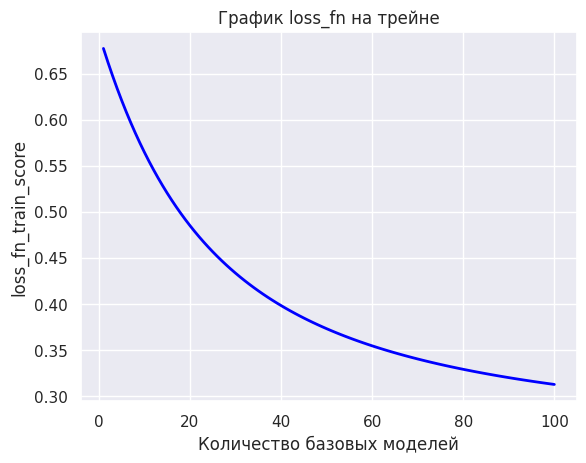

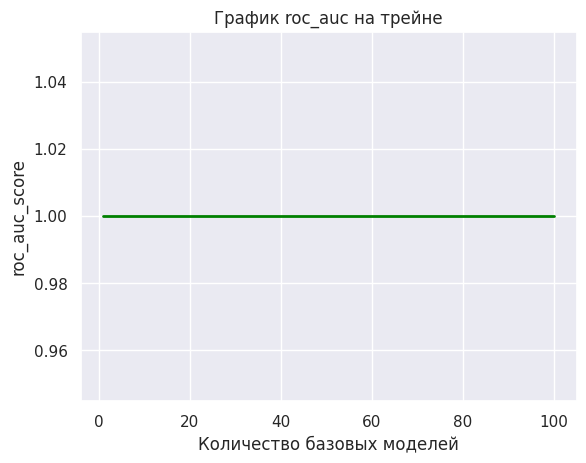

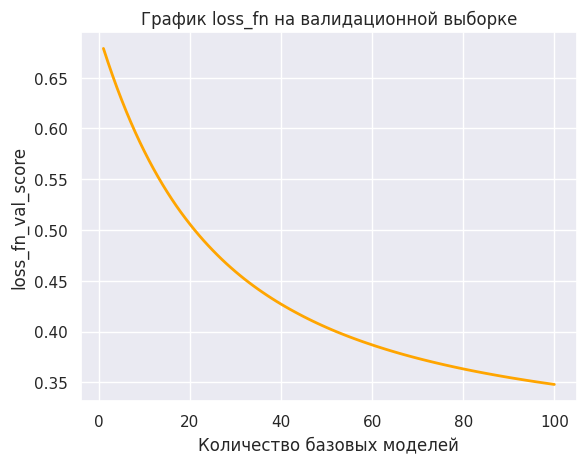

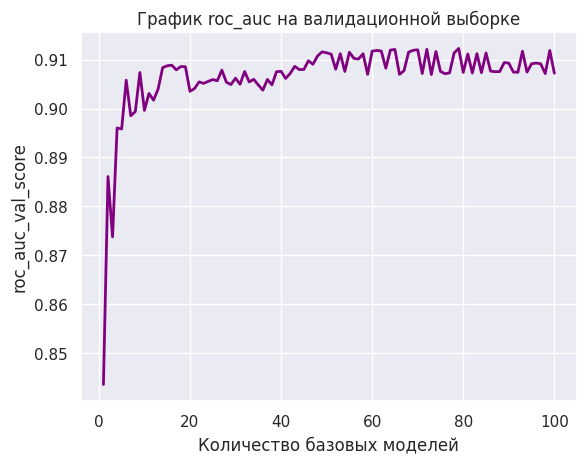

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9072
Test ROC-AUC 0.9048


In [ ]:
boosting = Boosting(n_estimators=100)

boosting.fit(X_train, y_train, X_valid, y_valid, plot=True) #я реализовал plot_history без передачи туда выборки, поскольку я сохранял историю на обучении

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(X_test).shape == (X_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

---

## Задание 2. Имплементация гиперпараметров (2.5 балла + 3.5 бонус)

Бустинг, как метод агрегации, предлагает несколько вариантов регуляризации без относительно базовой модели. В этом пункте предлагается имплементировать часть из них. При необходимости можете обратиться к реализациям в вашей любимой библиотеке, там могут быть дополнительные пояснения и/или ссылки на оригинальные статьи

<font color='lightcoral'>**Важно!**</font> После добавления каждого параметра проверьте, как это повлияет на качество. Специально крутить параметры не нужно, но важно увидеть, что перформанс модели изменился, в худшую или в лучшую сторону, для этого какие-то параметры нужны, пусть и от балды, <font color='lightcoral'>**дефолтные параметры не подойдут**</font>, они скорее для референса. Лучше всего это видно по графикам обучения <font color='lightcoral'>**на трейне и валидации**</font>, рекомендуется смотреть именно на них

### 2.1. Борьба с переобучением (0.5 балла)

Как известно, бустинги бывают склонны к переобучению. Чтобы этого не допустить, можно контролировать процесс обучения и проверять критерий останова на валидации. Реализуйте такую процедуру, не забудьте, что всю предобработку, что вы будете делать для трейна, нужно будет повторить на валидации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| <td colspan=3>`early_stopping_rounds`, `eval_set` |

Добавьте параметры:
- `early_stopping_rounds: int | None = 0` — число раундов для критерия останова. Если качество ухудшается на протяжении всех раундов подряд, останавливаем обучение
- `X_val`, `y_val` или `eval_set: Tuple[np.ndarray] | None = None` — валидацонная выборка, на которой будем проверять переобучение

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

    def partial_fit(self, X, y):
        new_model = self.base_model_class(**self.base_model_params)
        new_model.fit(X, y)
        return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            self.models.append(self.partial_fit(X_train, -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train)))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
                self.history['val_roc_auc'].append(self.score(self.eval_set[0], self.eval_set[1]))
                if i == 0:
                  best_score = self.history['val_roc_auc'][0]
                if self.history['val_roc_auc'][i] < best_score:
                    counter += 1
                    if counter == self.early_stopping_rounds:
                        break
                else:
                  counter = 0
                  best_score = self.history['val_roc_auc'][i]
        if plot:
            self.plot_history()

    def predict_proba(self, X):
            predictions = np.zeros(X.shape[0])
            for i in range(len(self.models)):
                predictions += self.learning_rate * self.gammas[i] * (self.models[i].predict(X))
            prob_1_st = self.sigmoid(predictions)
            prob_0 = 1 - prob_1_st
            probs = np.column_stack((prob_0, prob_1_st))
            return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, len(self.history['train_roc_auc']) + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейна')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, len(self.history['val_roc_auc']) + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

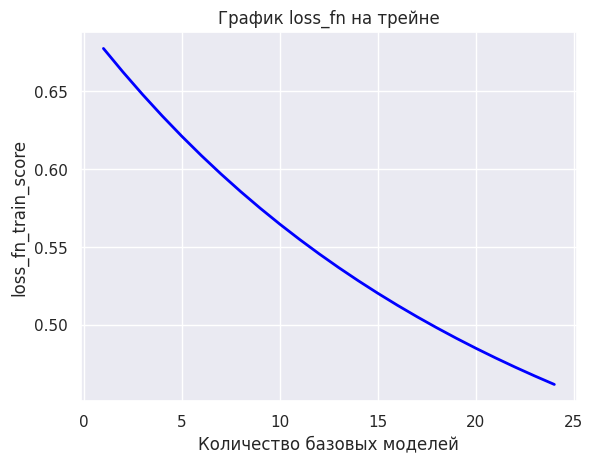

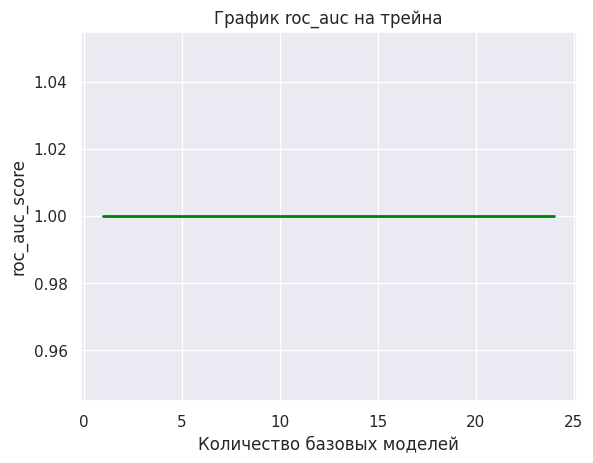

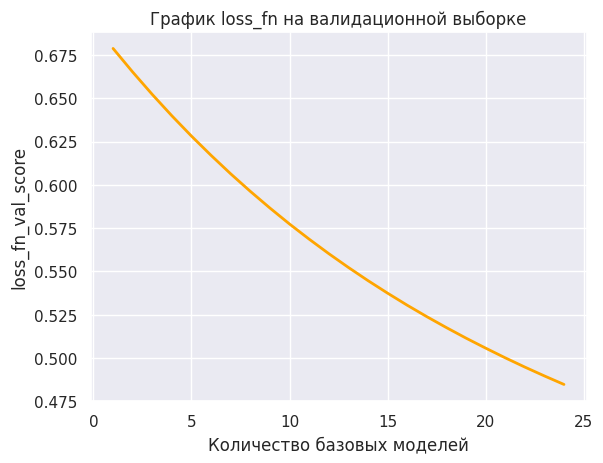

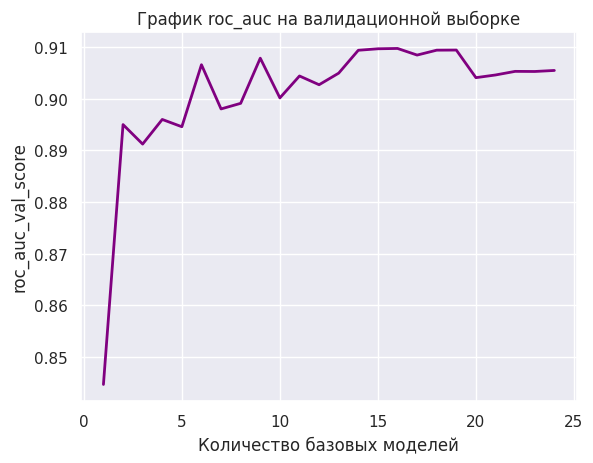

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9054
Test ROC-AUC 0.9025


In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
eval_set = (X_valid, y_valid)
boosting = Boosting(n_estimators=100, eval_set=eval_set, early_stopping_rounds=8)

boosting.fit(X_train, y_train, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. Бустинг линейных моделей (0.5 балла)

**<font color='plum'>Вопрос:** что произойдет при ансамблировании линейных моделей? Имеет ли это смысл?</font>

<font color='plum'>**Ответ:** на самом деле, поскольку линейные модели, особенно если их еще и решуляризовывать, оказываются довольно устойчивыми - то при ансамблировании у нас практически ничего не поменяется. То есть, ошибка в целом может упасть, но не намного

Давайте убедимся. Обучите бустинг, где в качестве базовой модели будет линейная регрессия. Обязательно сохраните историю функции потерь и зафиксируйте время обучения. Можно взять уже готовый из <font color='lightblue'>**XGBoost**</font>, но будьте готовы разобраться с тем, как оттуда достать историю обучения

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="gblinear")` | — | — |

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from typing import Optional

import time

def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.training_times = []

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

    def partial_fit(self, X, y):
        start_educ_time = time.time()
        new_model = self.base_model_class(**self.base_model_params)
        new_model.fit(X, y)
        end_educ_time = time.time()
        educ_time = end_educ_time - start_educ_time
        self.training_times.append(educ_time)
        return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            self.models.append(self.partial_fit(X_train, -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train)))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
        if plot:
            self.plot_history()

    def predict_proba(self, X):
            predictions = np.zeros(X.shape[0])
            for i in range(len(self.models)):
                predictions += self.learning_rate * self.gammas[i] * (self.models[i].predict(X))
            prob_1_st = self.sigmoid(predictions)
            prob_0 = 1 - prob_1_st
            probs = np.column_stack((prob_0, prob_1_st))
            return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

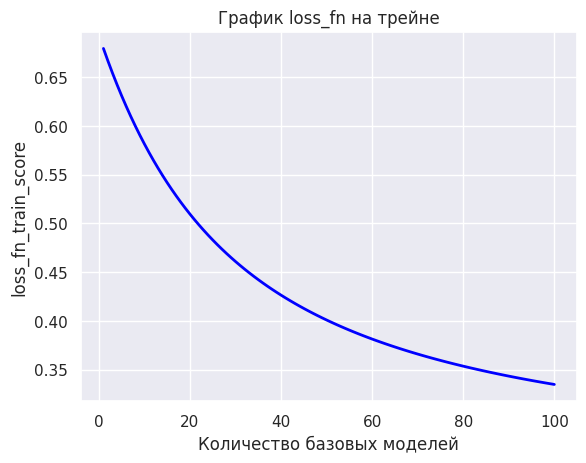

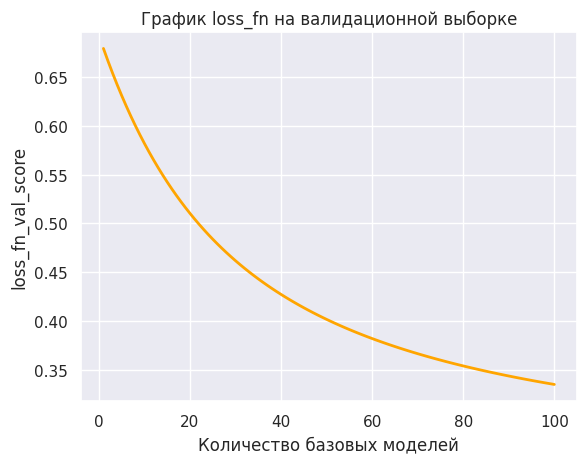

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
eval_set = (X_valid, y_valid)
boosting = Boosting(base_model_class=LinearRegression, eval_set=eval_set, n_estimators=100,)

boosting.fit(X_train, y_train, plot=True)

Теперь возьмите `sklearn.linear_model.SGDClassifier` иобучите на тех же данных. Не забудьте вытащить историю функции потерь

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss

sgd_classifier = SGDClassifier(loss='log_loss', max_iter=1000, random_state=42)

history_of_losses = []
time_for_1_educ = []
history_of_val_losses = []

for i in range(100):  # Сколько раз обучаемся
    start_educ_time = time.time()
    sgd_classifier.partial_fit(X_train, y_train, classes=np.unique(y_train))
    end_educ_time = time.time()

    y_pred_proba = sgd_classifier.predict_proba(X_train)
    current_loss = log_loss(y_train, y_pred_proba)
    history_of_losses.append(current_loss)

    y_pred_val_proba = sgd_classifier.predict_proba(X_valid)
    current_val_loss = log_loss(y_valid, y_pred_val_proba)
    history_of_val_losses.append(current_val_loss)

    educ_time = end_educ_time - start_educ_time
    time_for_1_educ.append(educ_time)

Покажите на одном графике изменение функции потерь для бустинга и SGD классификатора. Сравните следующие детали у бустинга и линейной модели:

- время обучения
- сходимость (как быстро, как стабильно и прочее)
- графики функции потерь на трейне и на валидации

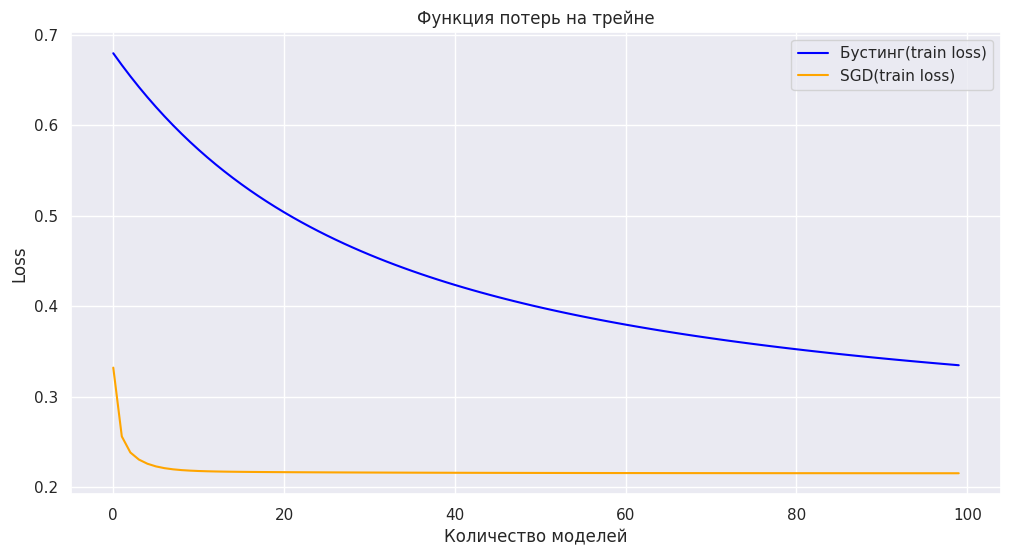

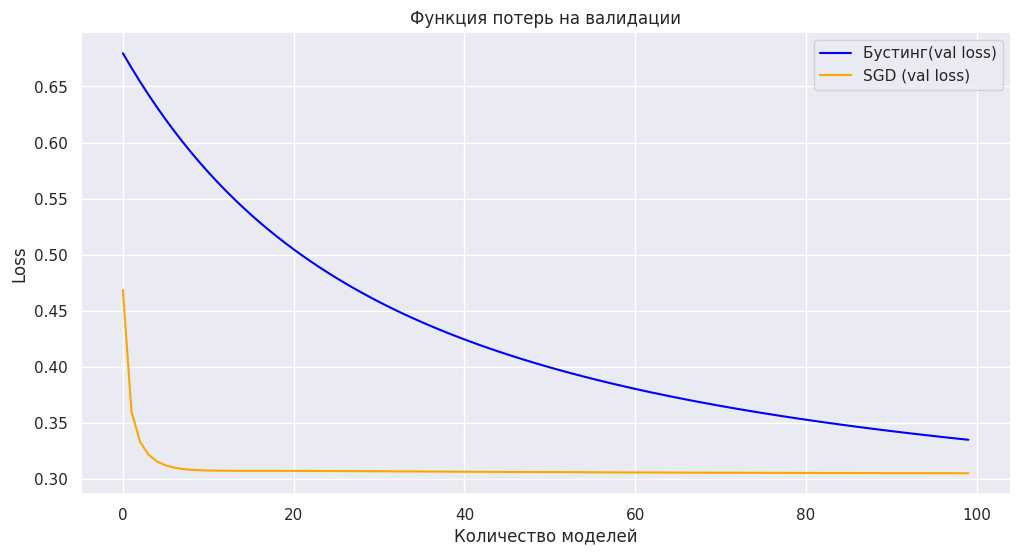

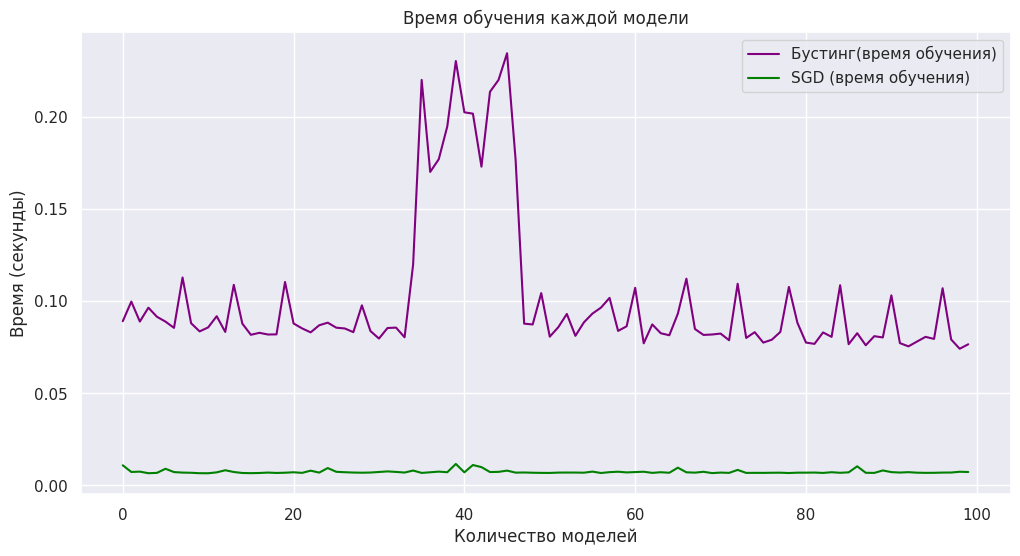

Сравнение сходимости:
Бустинг: Конечная функция потерь на трейне = 0.33485743662780826
SGD: Конечная функция потерь на трейне = 0.21551738331833445
Бустинг: Конечная функция потерь на валидации = 0.3348372865366869
SGD: Конечная функция потерь на валидации = 0.30497373635402086


In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
import matplotlib.pyplot as plt

    # График функции потерь на трейне
plt.figure(figsize=(12, 6))
plt.plot(boosting.history['train_loss'], label='Бустинг(train loss)', color='blue')
plt.plot(history_of_losses, label='SGD(train loss)', color='orange')
plt.title('Функция потерь на трейне')
plt.xlabel('Количество моделей')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График функции потерь на валидации
plt.figure(figsize=(12, 6))
plt.plot(boosting.history['val_loss'], label='Бустинг(val loss)', color='blue')
plt.plot(history_of_val_losses, label='SGD (val loss)', color='orange')
plt.title('Функция потерь на валидации')
plt.xlabel('Количество моделей')
plt.ylabel('Loss')
plt.legend()
plt.show()


# График времени обучения
plt.figure(figsize=(12, 6))
plt.plot(boosting.training_times, label='Бустинг(время обучения)', color='purple')
plt.plot(time_for_1_educ, label='SGD (время обучения)', color='green')
plt.title('Время обучения каждой модели')
plt.xlabel('Количество моделей')
plt.ylabel('Время (секунды)')
plt.legend()
plt.show()

# Сравнение сходимости
print("Сравнение сходимости:")
print(f"Бустинг: Конечная функция потерь на трейне = {boosting.history['train_loss'][-1]}")
print(f"SGD: Конечная функция потерь на трейне = {history_of_losses[-1]}")

print(f"Бустинг: Конечная функция потерь на валидации = {boosting.history['val_loss'][-1]}")
print(f"SGD: Конечная функция потерь на валидации = {history_of_val_losses[-1]}")

<font color='plum'>**Вопрос:** Какой вывод вы можете сделать?</font>

<font color='plum'>**Ответ:** можно сделать вывод, что SGD сходится намного быстрее, чем бустинг, поскольку в бустинге у нас добавляются новые модели, которые могут не всегда показывать правильное направление в сторону минимума и поэтому бустинг может колбасить. Возможно потери больше в бустинге, поскольку линейная регрессия не очень подходит для классификации. Что касается времени - понятно, что бустинг будет более нестабильный, поскольку он может не всегда показывать правильные направления, поэтому в какие-то моменты может начать немного расходиться и время на обучение может быть выше

### 2.2. Бутстрап (0.5 балла)
Как известно, при обучении базовых алгоритмов в беггинге, используется бутстрапированная выборка. Звучит хайпово, почему бы не попробовать сделать то же самое в бустинге?

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `subsample`, — | `subsample`, `bagging`| `subsample`, `bootstrap_type`|

Вам нужно реализовать параметры:
- `subsample: float | int = 1.0` — доля или число объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей). Соответствует бутстрапу типа `Bernoulli`. Каждый объект либо входит в подвыборку, либо нет
- `bagging_temperature: float | int = 1.0` — веса объектов, которые попадают в выборку. Соответствует бутстрапу типа `Bayesian`. Каждый объект имеет определенный вес $t$, на который впоследствии домножается по формуле $w = (-\log(X))^t$, где $X \sim {U[0, 1]}$, после чего попадает в выборку. Таким образом можно сделать симуляцию повторений
- `bootstrap_type: str | None = 'Bernoulli'` — тип бутстрапа

<font color='plum'>**Вопрос:** как бутстрап может помочь в обучении с точки зрения смещения, разброса и вообще?</font>

<font color='plum'>**Ответ:** с точки зрения смещения бутстрап будет ухудшать каждую базовую модель, поскольку теперь мы не используем все данные, а значит, не можем узнать все зависимости и наша модель хуже начинает предсказывать на обучающей выборке. Тем не менее, у композиции смещение будет ниже, потому что каждая модель запоминает закономерности только на части данных, а потому не подстраиваются под шум, и ансамбль уже учитывает недочеты одной модели и компенсирует их правильными ответами другой, в итоге выдавая хорошие результаты.Также, теперь модели менее переобучаются, а потому разброс должен быть меньше. В целом, бутстрап улучшает обобщающую способность модели, поскольку теперь модель не переобучается так сильно, не учитывает шум в данных и не подстраивается под него, а следовательно, лучше обобщается

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = 'Bernoulli',
    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

    def partial_fit(self, X, y):
        X = X.toarray()
        if isinstance(self.subsample, float):
            subsample_size = int(self.subsample * X.shape[0])
        else:
            subsample_size = self.subsample
        if self.bootstrap_type == 'Bernoulli':
            indexes = np.random.choice(X.shape[0], size=subsample_size, replace=False)
            X_needed = X[indexes]
            y_needed = y[indexes]
        else:
          weights = (-np.log(np.random.uniform(0, 1)))**self.bagging_temperature
          X_needed = X * weights
          y_needed = y * weights
        new_model = self.base_model_class(**self.base_model_params)
        new_model.fit(X_needed, y_needed)
        return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            self.models.append(self.partial_fit(X_train, -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train)))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
                self.history['val_roc_auc'].append(self.score(self.eval_set[0], self.eval_set[1]))
                if i == 0:
                  best_score = self.history['val_roc_auc'][0]
                if self.history['val_roc_auc'][i] < best_score:
                    counter += 1
                    if counter == self.early_stopping_rounds:
                        break
                else:
                  counter = 0
                  best_score = self.history['val_roc_auc'][i]
        if plot:
            self.plot_history()

    def predict_proba(self, X):
            predictions = np.zeros(X.shape[0])
            for i in range(len(self.models)):
                predictions += self.learning_rate * self.gammas[i] * (self.models[i].predict(X))
            prob_1_st = self.sigmoid(predictions)
            prob_0 = 1 - prob_1_st
            probs = np.column_stack((prob_0, prob_1_st))
            return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, len(self.history['train_roc_auc']) + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейна')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, len(self.history['val_roc_auc']) + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

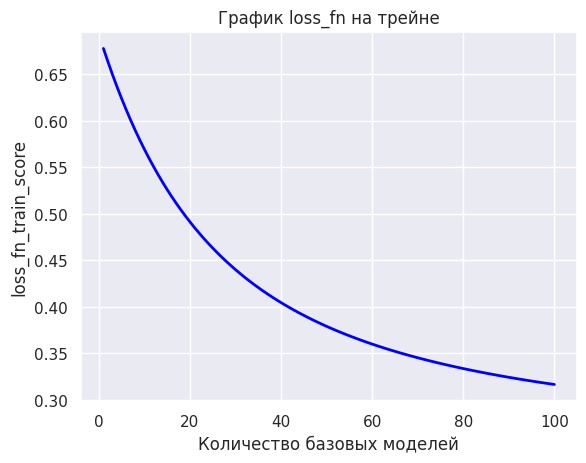

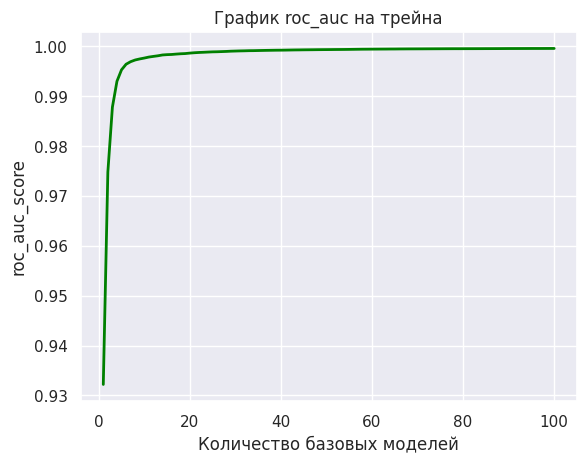

Train ROC-AUC 0.9996
Valid ROC-AUC 0.9284
Test ROC-AUC 0.9226


In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
boosting = Boosting(n_estimators=100, bootstrap_type = 'Bernoulli', subsample = 0.5)

boosting.fit(X_train, y_train, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

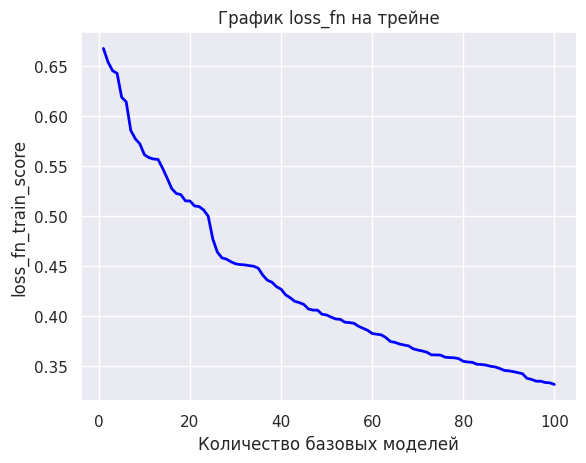

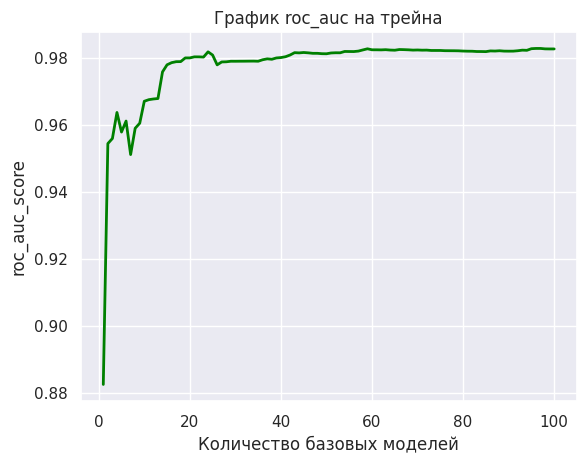

Train ROC-AUC 0.9826
Valid ROC-AUC 0.9299
Test ROC-AUC 0.9213


In [ ]:
boosting = Boosting(n_estimators=100, bootstrap_type = 'Bayesian', bagging_temperature = 0.8)

boosting.fit(X_train, y_train, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### Бонус. GOSS (0.5 балла)

Заметим, что во время обучения не все объекты одинаково важны. Один из вариантов это исправить — ввести какие-то веса на объекты, однако можно пойти чуть хитрее. В <font color='lightgreen'>**LightGBM**</font> придумали подход [Gradient-based One-side Sampling](https://www.microsoft.com/en-us/research/wp-content/uploads/2017/11/lightgbm.pdf)

Давайте оценивать важность объектов в отдельный момент обучения нового дерева. Будем считать, какой антиградиент привносит каждый объект. Далее разобъем градиенты на 2 группы. Объекты с большими градиентами берутся все, с маленькими — только часть, по аналогии с бутстрапом, с отрицательными — выкидываются. И не забываем домножить на фактор, чтобы учесть выкинутые объекты. Подробнее в статье

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | `bagging='goss'`| `bootstrap_type='MVS'`|

Параметры, которые нужно сделать:

- `goss: bool | None = False` — GOSS бустинг или нет
- `goss_k: float | int = 0.2` — доля объектов, градиенты которых будем считать большими. Все остальное — маленькими
- `subsample: float | int = 0.3` — параметры сэмплинга для маленьких градиентов из пункта 2.1

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = 'Bernoulli',
        goss: bool | None = False,
        goss_k: float | int = 0.2

    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

        self.goss = goss
        self.goss_k = goss_k

    def goss_boosting(self, X, gradients, goss_k, subsample):
        gradients_abs = np.abs(gradients)
        sorted_indexes = np.argsort(-gradients_abs) #получаем индексы аргументов по убыванию

        if isinstance(goss_k, float):
            mask = int(goss_k * X.shape[0])
        else:
            mask = goss_k
        large_gradients_indexes = sorted_indexes[:mask]
        small_gradients_indexes = sorted_indexes[mask:]

        if isinstance(subsample, float):
            subsample_size = int(subsample * len(small_gradients_indexes))
            factor = (1.0 - subsample) / subsample
        else:
            subsample_size = min(subsample, len(small_gradients_indexes))
            factor = (len(small_gradients_indexes) - subsample)/subsample

        if subsample == 1.0 or subsample == len(small_gradients_indexes):
            small_semp_indexes = small_gradients_indexes
            factor = 1.0
        else:
            if isinstance(subsample, float):
              factor = (1.0 - subsample) / subsample
            else:
              factor = (len(small_gradients_indexes) - subsample)/subsample

            small_semp_indexes = np.random.choice(small_gradients_indexes, size=subsample_size, replace=False)

        needed_indexes = np.concatenate([large_gradients_indexes, small_semp_indexes])
        weights = np.full(len(needed_indexes), 1.0)
        if len(small_semp_indexes) > 0:
            weights[len(large_gradients_indexes):] = factor
        return X[needed_indexes, :], needed_indexes, weights

    def partial_fit(self, X, y):
        if self.goss:
            X_needed, needed_indexes, weights = self.goss_boosting(X, y, self.goss_k, self.subsample)
            y_needed = y[needed_indexes]
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed, sample_weight=weights)
            return new_model
        else:
            X = X.toarray()
            if isinstance(self.subsample, float):
                subsample_size = int(self.subsample * X.shape[0])
            else:
                subsample_size = self.subsample
            if self.bootstrap_type == 'Bernoulli':
                indexes = np.random.choice(X.shape[0], size=subsample_size, replace=False)
                X_needed = X[indexes]
                y_needed = y[indexes]
            else:
              weights = (-np.log(np.random.uniform(0, 1)))**self.bagging_temperature
              X_needed = X * weights
              y_needed = y * weights
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed)
            return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            self.models.append(self.partial_fit(X_train, -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train)))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
                self.history['val_roc_auc'].append(self.score(self.eval_set[0], self.eval_set[1]))
                if i == 0:
                  best_score = self.history['val_roc_auc'][0]
                if self.history['val_roc_auc'][i] < best_score:
                    counter += 1
                    if counter == self.early_stopping_rounds:
                        break
                else:
                  counter = 0
                  best_score = self.history['val_roc_auc'][i]
        if plot:
            self.plot_history()

    def predict_proba(self, X):
            predictions = np.zeros(X.shape[0])
            for i in range(len(self.models)):
                predictions += self.learning_rate * self.gammas[i] * (self.models[i].predict(X))
            prob_1_st = self.sigmoid(predictions)
            prob_0 = 1 - prob_1_st
            probs = np.column_stack((prob_0, prob_1_st))
            return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, len(self.history['train_roc_auc']) + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейна')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, len(self.history['val_roc_auc']) + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

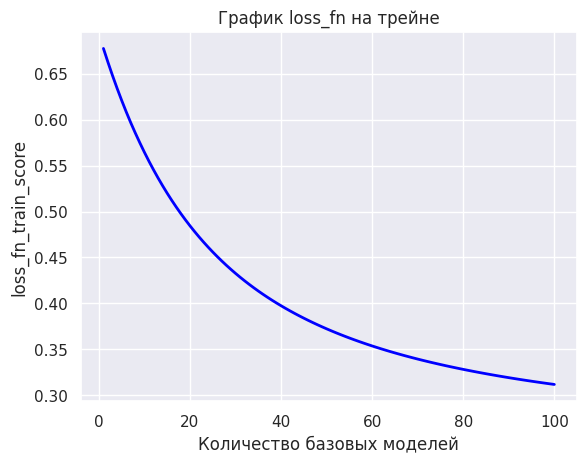

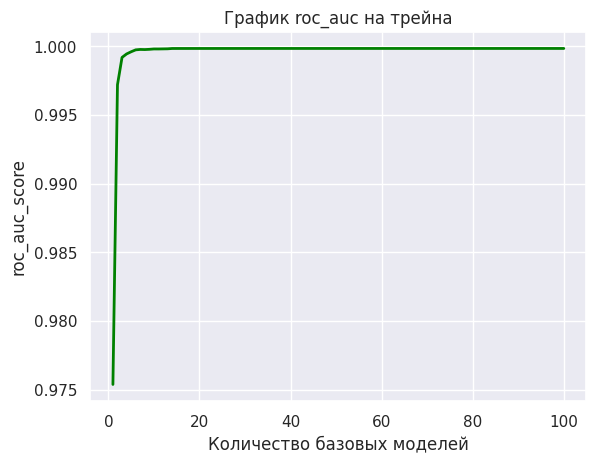

Train ROC-AUC 0.9998
Valid ROC-AUC 0.9145
Test ROC-AUC 0.9132


In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
boosting = Boosting(n_estimators=100, goss=True, goss_k=0.3, subsample=0.8)

boosting.fit(X_train, y_train, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

### 2.3. Работа с признаками (1 балл)

1. Помимо выбора случайных объектов, есть идея выбирать случайное подмножество признаков, заложенная в Random Forest. Мотивация это делать точно та же самая, что и в бутстрапировании, за это будет отвечать `rsm`

2. С другой стороны, вместо того, чтобы выкидывать признаки, можно попробовать проредить их множество значений, применив бинаризацию. В идеале это стоит делать с датасетом до обучения модели, но не обязательно, можно, например, на этапе `fit`, а в `partial_fit` приходит уже квантизованный датасет. Для этого существует множество алгоритмов, мы предлагаем сделать два наиболее простых:

- $\text{Uniform}$. Значения признака $[\min f_i, \max f_i]$ отображаются в `nbins` отрезков одинаковой длины, которые полностью покрывают интервал
- $\text{Quantile}$. Тот же самый отрезок сортируется и бьется на `nbins` квантилей от 0 до 1

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `colsample_bytree`, `tree_method` | `colsample_bytree`, `max_bin`| `rsm`, `quantize(...)`|

Нужно добавить параметры:
- `rsm: float | int = 1.0` — доля или число признаков, участвующих в обучении модели. Каждый признак либо входит, либо не входит в пул, на котором обучается базовый алгоритм, по аналогии с бутстрапом Бернулли
- `quantization_type: str | None = None` — тип квантизации, если она есть
- `nbins: int = 255` — число бинов для квантизации. Игнорируем, если тип квантизации не указан

<font color='plum'>**Вопрос**: как квантизация поможет в обработке выбросов и нанов?</font>

<font color='plum'>**Ответ**: Во-первых, выбросы зашумляют данные и не дают модели нормально обучиться, поскольку она может начать подстраиваться под них, поскольку выбросы теперь кодируются просто бином. Что касается нанов - теперь их можно заменить на медиану или среднее, в зависимости от того, в какой диапазон они попадают. Надо просто меньше думать как обрабатывать наны, поскольку когда они в группе определенной - то скорее всего среднее предсказанное нами значение будет верным.

<font color='plum'>**Вопрос**: можно ли просто заполнить наны каким-то числом? Имеет ли значение, что это за число (-1, -100, -1e32)?</font>

<font color='plum'>**Ответ**: вообще, лучше заполнять наны исходя из анализа данных, а не просто каким-то рандомным числом. Поскольку это может вынудить модель подстраиваться под шум и привести к плохой обобщаемости. То есть, конечно, заполнение рандомным числом может и ускорит немного работу с данными, но скорее всего не улучшит модель

In [ ]:
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = 'Bernoulli',
        goss: bool | None = False,
        goss_k: float | int = 0.2,
        rsm: float | int = 1.0,
        quantization_type: str | None = None,
        nbins: int = 255

    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

        self.goss = goss
        self.goss_k = goss_k

        self.rsm = rsm
        self.quantization_type = quantization_type
        self.nbins = nbins
        self.quantization_params = [] #добавляем списки, чтобы в них сохранять наши найденные квантили или выбранные признаки для применения после обучения
        self.selected_features = []


    def select_features(self, X, rsm):
        if isinstance(rsm, float):
            feat_selected_q = int(X.shape[1] * rsm)
        else:
            feat_selected_q = rsm
        selected_f = np.random.choice(X.shape[1], size=feat_selected_q, replace=False)
        return selected_f

    def quantize_data(self, X, quantization_type, nbins):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        X_quant = X.copy()
        if quantization_type == 'uniform':
            if not self.quantization_params: #проверяем, что у нас список пустой, чтобы понять, на какой стадии мы находимся - на обучении или на тестировании
                for i in range(X.shape[1]):
                    min_feat = np.min(X[:, i])
                    max_feat = np.max(X[:, i])
                    width_of_bin = (max_feat - min_feat) / nbins
                    self.quantization_params.append({'min': min_feat, 'width_of_bin': width_of_bin})
                    X_quant[:, i] = np.floor((X[:, i] - min_feat) / width_of_bin) #тут мы специально берем и окргуляем именно блиайшего целого снизу, поскольку иначе неправильно будут учитываться объекты в бины
            else: #тут уже, если мы уже все создали - то просто применяем готовые бины к новым выборкам
                for i in range(X.shape[1]):
                    min_feat = self.quantization_params[i]['min']
                    width_of_bin = self.quantization_params[i]['width_of_bin']
                    X_quant[:, i] = np.floor((X[:, i] - min_feat) / width_of_bin)
                    X_quant[:, i] = np.clip(X_quant[:, i], 0, nbins - 1)
        elif quantization_type == 'quantile':
            if not self.quantization_params:
                for i in range(X.shape[1]):
                    sorted_feats = np.sort(X[:, i])
                    bins = np.linspace(0, 1, nbins + 1)[1:-1] #тут мы оставляем все бины, кроме первого и последнего, поскольку они не нужны нам
                    quantiles = np.quantile(sorted_feats, bins) #тут мы получаем все необходимые граничные значения
                    self.quantization_params.append({'quantiles': quantiles})
                    X_quant[:, i] = np.digitize(X[:, i], quantiles) #распределяем объекты по квантилям
            else:
                for i in range(X.shape[1]):
                    quantiles = self.quantization_params[i]['quantiles']
                    X_quant[:, i] = np.digitize(X[:, i], quantiles)
        return X_quant


    def goss_boosting(self, X, gradients, goss_k, subsample): #создадим отдельную функцию, потому что иначе partial fit офигеет от количества обработки данных
        gradients_abs = np.abs(gradients)
        sorted_indexes = np.argsort(-gradients_abs) #получаем индексы аргументов по убыванию

        if isinstance(goss_k, float):
            mask = int(goss_k * X.shape[0])
        else:
            mask = goss_k
        large_gradients_indexes = sorted_indexes[:mask]
        small_gradients_indexes = sorted_indexes[mask:]

        if isinstance(subsample, float):
            subsample_size = int(subsample * len(small_gradients_indexes))
            factor = (1.0 - subsample) / subsample
        else:
            subsample_size = min(subsample, len(small_gradients_indexes))
            factor = (len(small_gradients_indexes) - subsample)/subsample

        if subsample == 1.0 or subsample >= len(small_gradients_indexes):
            small_semp_indexes = small_gradients_indexes
            factor = 1.0
        else:
            if isinstance(subsample, float):
              factor = (1.0 - subsample) / subsample
            else:
              factor = (len(small_gradients_indexes) - subsample)/subsample

            small_semp_indexes = np.random.choice(small_gradients_indexes, size=subsample_size, replace=False)

        needed_indexes = np.concatenate([large_gradients_indexes, small_semp_indexes])
        weights = np.full(len(needed_indexes), 1.0)
        if len(small_semp_indexes) > 0:
            weights[len(large_gradients_indexes):] = factor
        return X[needed_indexes, :], needed_indexes, weights

    def partial_fit(self, X, y):
        if self.goss:
            X_needed, needed_indexes, weights = self.goss_boosting(X, y, self.goss_k, self.subsample)
            y_needed = y[needed_indexes]
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed, sample_weight=weights)
            return new_model
        else:
            if not isinstance(X, np.ndarray):
                X = X.toarray()
            if isinstance(self.subsample, float):
                subsample_size = int(self.subsample * X.shape[0])
            else:
                subsample_size = self.subsample
            if self.bootstrap_type == 'Bernoulli':
                indexes = np.random.choice(X.shape[0], size=subsample_size, replace=False)
                X_needed = X[indexes]
                y_needed = y[indexes]
            else:
              weights = (-np.log(np.random.uniform(0, 1)))**self.bagging_temperature
              X_needed = X * weights
              y_needed = y * weights
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed)
            return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        if self.quantization_type is not None:
            X_train = self.quantize_data(X_train, self.quantization_type, self.nbins)
            if self.eval_set is not None:
                self.eval_set = list(self.eval_set)
                self.eval_set[0] = self.quantize_data(self.eval_set[0], self.quantization_type, self.nbins)
                self.eval_set = tuple(self.eval_set)

        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(self.eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            sel_feats = self.select_features(X_train, self.rsm)
            self.selected_features.append(sel_feats)
            self.models.append(self.partial_fit(X_train[:, sel_feats], -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train[:, sel_feats])))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train[:, sel_feats]))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0][:, sel_feats]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
                self.history['val_roc_auc'].append(self.score(self.eval_set[0], self.eval_set[1]))
                if i == 0:
                  best_score = self.history['val_roc_auc'][0]
                if self.history['val_roc_auc'][i] < best_score:
                    counter += 1
                    if counter == self.early_stopping_rounds:
                        break
                else:
                  counter = 0
                  best_score = self.history['val_roc_auc'][i]
        if plot:
            self.plot_history()

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])
        for i in range(len(self.models)):
            selected_features = self.selected_features[i]
            predictions += self.learning_rate * self.gammas[i] * self.models[i].predict(X[:, selected_features])
        prob_1_st = self.sigmoid(predictions)
        prob_0 = 1 - prob_1_st
        probs = np.column_stack((prob_0, prob_1_st))
        return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, len(self.history['train_roc_auc']) + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейна')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, len(self.history['val_roc_auc']) + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

In [ ]:
eval_set = (X_valid, y_valid)
boosting = Boosting(n_estimators=100, rsm=0.8, quantization_type='quantile', eval_set=eval_set)

boosting.fit(X_train, y_train, plot=True)

print(f'Train ROC-AUC {boosting.score(X_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(X_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(X_test, y_test):.4f}')

KeyboardInterrupt: 

### Бонус. Квантизация (1.5 балл)

В текущих имплементациях бустинга используются более сложные методы квантизации. К сожалению, способы выше страдают либо от неравноправности бинов — в каких-то объектов больше, в каких-то меньше, либо от того, что целевая переменная от бинов зависит опосредованно. Предлагается это исправить следующими способами:

1. $\text{MinEntropy}$. Это [один из методов](https://catboost.ai/docs/en/concepts/quantization), который используется для бинаризации в <font color='palegoldenrod'>**CatBoost**</font>, остальные на него очень похожи. Будем жадно набирать бины так, чтобы энтропия объектов внутри ($\sum_{i \in \text{bin}} x_i\log(x_i)$) была как можно меньше. Сделать такое разбиение руками непросто, но вам эта задача должна что-то напоминать
   
2. $\text{PiecewiseEncoding}$. Это относительно свежий метод для [табличных трансформеров](https://arxiv.org/pdf/2203.05556). Суть заключается в том, что бины для квантизации будем брать не с потолка, а именно те, что нужны для разбиения таргета. (В статье делается кодирование в вектор длины $T$, где $T$ число бинов, в нашем случае это излишне, бинов можно оставить столько же, но взять лмшь закодированную по формуле часть)

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| — | — | `feature_border_type="Piecewise"` |

Нужно добавить опцию:

- `'MinEntropy'` для `quantization_type` — какую квантизацию используем

Реализуйте оба способа подсчета (или один, но тогда балл неполный) и сравните, удалось ли улучшить качество?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 2.4. Важность признаков (0.5 балла)

Поскольку наша базовая модель — это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными — иначе вы что-то сделали не так). Разумеется, способ не единственный, если хочется, посмотрите в документации

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `model.get_score()` | `lightgbm.importance()` | `model.get_feature_importance()` |

Допишите к бустингу:
- `feature_importances_` — атрибут, который возвращает важность признаков, согласно методу выше

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
from __future__ import annotations
import matplotlib.pyplot as plt
from collections import defaultdict

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor

from typing import Optional


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
        self,
        base_model_class = DecisionTreeRegressor,
        base_model_params: Optional[dict] = None,
        n_estimators: int = 10,
        learning_rate: float = 0.1,
        early_stopping_rounds: int | None = 10,
        eval_set: Tuple[np.ndarray] | None = None,
        subsample: float | int = 1.0,
        bagging_temperature: float | int = 1.0,
        bootstrap_type: str | None = 'Bernoulli',
        goss: bool | None = False,
        goss_k: float | int = 0.2,
        rsm: float | int = 1.0,
        quantization_type: str | None = None,
        nbins: int = 255

    ):
        self.base_model_class = base_model_class
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate

        self.history = defaultdict(list) # {"train_roc_auc": [], "train_loss": [], ...}

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y *self.sigmoid(-y * z)  # Исправьте формулу на правильную.

        self.early_stopping_rounds = early_stopping_rounds
        self.eval_set = eval_set

        self.subsample = subsample
        self.bagging_temperature = bagging_temperature
        self.bootstrap_type = bootstrap_type

        self.goss = goss
        self.goss_k = goss_k

        self.rsm = rsm
        self.quantization_type = quantization_type
        self.nbins = nbins
        self.quantization_params = [] #добавляем списки, чтобы в них сохранять наши найденные квантили или выбранные признаки для применения после обучения
        self.selected_features = []

    def select_features(self, X, rsm):
        if isinstance(rsm, float):
            feat_selected_q = int(X.shape[1] * rsm)
        else:
            feat_selected_q = rsm
        selected_f = np.random.choice(X.shape[1], size=feat_selected_q, replace=False)
        return selected_f

    def quantize_data(self, X, quantization_type, nbins):
        if not isinstance(X, np.ndarray):
            X = X.toarray()
        X_quant = X.copy()
        if quantization_type == 'uniform':
            if not self.quantization_params: #проверяем, что у нас список пустой, чтобы понять, на какой стадии мы находимся - на обучении или на тестировании
                for i in range(X.shape[1]):
                    min_feat = np.min(X[:, i])
                    max_feat = np.max(X[:, i])
                    width_of_bin = (max_feat - min_feat) / nbins
                    self.quantization_params.append({'min': min_feat, 'width_of_bin': width_of_bin})
                    X_quant[:, i] = np.floor((X[:, i] - min_feat) / width_of_bin) #тут мы специально берем и окргуляем именно блиайшего целого снизу, поскольку иначе неправильно будут учитываться объекты в бины
            else: #тут уже, если мы уже все создали - то просто применяем готовые бины к новым выборкам
                for i in range(X.shape[1]):
                    min_feat = self.quantization_params[i]['min']
                    width_of_bin = self.quantization_params[i]['width_of_bin']
                    X_quant[:, i] = np.floor((X[:, i] - min_feat) / width_of_bin)
                    X_quant[:, i] = np.clip(X_quant[:, i], 0, nbins - 1)
        elif quantization_type == 'quantile':
            if not self.quantization_params:
                for i in range(X.shape[1]):
                    sorted_feats = np.sort(X[:, i])
                    bins = np.linspace(0, 1, nbins + 1)[1:-1] #тут мы оставляем все бины, кроме первого и последнего, поскольку они не нужны нам
                    quantiles = np.quantile(sorted_feats, bins) #тут мы получаем все необходимые граничные значения
                    self.quantization_params.append({'quantiles': quantiles})
                    X_quant[:, i] = np.digitize(X[:, i], quantiles) #распределяем объекты по квантилям
            else:
                for i in range(X.shape[1]):
                    quantiles = self.quantization_params[i]['quantiles']
                    X_quant[:, i] = np.digitize(X[:, i], quantiles)
        return X_quant


    def goss_boosting(self, X, gradients, goss_k, subsample): #создадим отдельную функцию, потому что иначе partial fit офигеет от количества обработки данных
        gradients_abs = np.abs(gradients)
        sorted_indexes = np.argsort(-gradients_abs) #получаем индексы аргументов по убыванию

        if isinstance(goss_k, float):
            mask = int(goss_k * X.shape[0])
        else:
            mask = goss_k
        large_gradients_indexes = sorted_indexes[:mask]
        small_gradients_indexes = sorted_indexes[mask:]

        if isinstance(subsample, float):
            subsample_size = int(subsample * len(small_gradients_indexes))
            factor = (1.0 - subsample) / subsample
        else:
            subsample_size = min(subsample, len(small_gradients_indexes))
            factor = (len(small_gradients_indexes) - subsample)/subsample

        if subsample == 1.0 or subsample >= len(small_gradients_indexes):
            small_semp_indexes = small_gradients_indexes
            factor = 1.0
        else:
            if isinstance(subsample, float):
              factor = (1.0 - subsample) / subsample
            else:
              factor = (len(small_gradients_indexes) - subsample)/subsample

            small_semp_indexes = np.random.choice(small_gradients_indexes, size=subsample_size, replace=False)

        needed_indexes = np.concatenate([large_gradients_indexes, small_semp_indexes])
        weights = np.full(len(needed_indexes), 1.0)
        if len(small_semp_indexes) > 0:
            weights[len(large_gradients_indexes):] = factor
        return X[needed_indexes, :], needed_indexes, weights


    def important_features(self, X_train):

        n_features = X_train.shape[1]  # Общее количество признаков

        feature_importances = np.zeros(n_features) #массив, чтобы потом суммировать значения признаков

        for i in range(len(self.models)):
            selected_features = self.selected_features[i]
            tree_importances = self.models[i].feature_importances_

            full_importances = np.zeros(n_features)#еще раз создаем массив из нулей, потому что мы его сейчас будем заполнять, а потом прибавлять к массиву суммарному
            full_importances[selected_features] = tree_importances
            feature_importances += full_importances

        feature_importances /= len(self.models)
        feature_importances /= np.sum(feature_importances)
        return feature_importances

    def partial_fit(self, X, y):
        if self.goss:
            X_needed, needed_indexes, weights = self.goss_boosting(X, y, self.goss_k, self.subsample)
            y_needed = y[needed_indexes]
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed, sample_weight=weights)
            return new_model
        else:
            if not isinstance(X, np.ndarray):
                X = X.toarray()
            if isinstance(self.subsample, float):
                subsample_size = int(self.subsample * X.shape[0])
            else:
                subsample_size = self.subsample
            if self.bootstrap_type == 'Bernoulli':
                indexes = np.random.choice(X.shape[0], size=subsample_size, replace=False)
                X_needed = X[indexes]
                y_needed = y[indexes]
            else:
              weights = (-np.log(np.random.uniform(0, 1)))**self.bagging_temperature
              X_needed = X * weights
              y_needed = y * weights
            new_model = self.base_model_class(**self.base_model_params)
            new_model.fit(X_needed, y_needed)
            return new_model

    def fit(self, X_train, y_train, X_val=None, y_val=None, plot=False):
        """
        :param X_train: features array (train set)
        :param y_train: targets array (train set)
        :param X_val: features array (eval set)
        :param y_val: targets array (eval set)
        :param plot: bool
        """
        if self.quantization_type is not None:
            X_train = self.quantize_data(X_train, self.quantization_type, self.nbins)
            if self.eval_set is not None:
                self.eval_set = list(self.eval_set)
                self.eval_set[0] = self.quantize_data(self.eval_set[0], self.quantization_type, self.nbins)
                self.eval_set = tuple(self.eval_set)

        train_predictions = np.zeros(y_train.shape[0])
        if self.eval_set is not None:
            val_predictions = np.zeros(self.eval_set[1].shape[0])
            counter = 0

        for i in range(self.n_estimators):
            derivative = self.loss_derivative(y_train, train_predictions)
            sel_feats = self.select_features(X_train, self.rsm)
            self.selected_features.append(sel_feats)
            self.models.append(self.partial_fit(X_train[:, sel_feats], -derivative))
            new_model = self.models[i]
            self.gammas.append(self.find_optimal_gamma(y_train, train_predictions, new_model.predict(X_train[:, sel_feats])))
            train_predictions = train_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_train[:, sel_feats]))

            self.history['train_loss'].append(self.loss_fn(y_train, train_predictions))
            self.history['train_roc_auc'].append(self.score(X_train, y_train))
            '''if X_val is not None
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(X_val))
                self.history['val_loss'].append(self.loss_fn(y_val, val_predictions))
                self.history['val_roc_auc'].append(self.score(X_val, y_val))'''

            if self.eval_set is not None:
                val_predictions = val_predictions + self.learning_rate * self.gammas[i] * (new_model.predict(self.eval_set[0][:, sel_feats]))
                self.history['val_loss'].append(self.loss_fn(self.eval_set[1], val_predictions))
                self.history['val_roc_auc'].append(self.score(self.eval_set[0], self.eval_set[1]))
                if i == 0:
                  best_score = self.history['val_roc_auc'][0]
                if self.history['val_roc_auc'][i] < best_score:
                    counter += 1
                    if counter == self.early_stopping_rounds:
                        break
                else:
                  counter = 0
                  best_score = self.history['val_roc_auc'][i]
        if plot:
            self.plot_history()

    def predict_proba(self, X):
        predictions = np.zeros(X.shape[0])
        for i in range(len(self.models)):
            selected_features = self.selected_features[i]
            predictions += self.learning_rate * self.gammas[i] * self.models[i].predict(X[:, selected_features])
        prob_1_st = self.sigmoid(predictions)
        prob_0 = 1 - prob_1_st
        probs = np.column_stack((prob_0, prob_1_st))
        return probs

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]
        return gammas[np.argmin(losses)]

    def score(self, X, y):
        return score(self, X, y)

    def plot_history(self): #поскольку мы делаем добавление сразу во время обучения - то не буду принимать выборку
        """
        :param X: features array (any set)
        :param y: targets array (any set)
        """
        plt.plot(range(1, len(self.history['train_loss']) + 1), self.history['train_loss'], color='blue', linewidth=2)
        plt.title('График loss_fn на трейне')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('loss_fn_train_score')
        plt.show()

        plt.plot(range(1, len(self.history['train_roc_auc']) + 1), self.history['train_roc_auc'], color='green', linewidth=2)
        plt.title('График roc_auc на трейна')
        plt.xlabel('Количество базовых моделей')
        plt.ylabel('roc_auc_score')
        plt.show()

        if 'val_loss' in self.history:
            plt.plot(range(1, len(self.history['val_loss']) + 1), self.history['val_loss'], color='orange', linewidth=2)
            plt.title('График loss_fn на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('loss_fn_val_score')
            plt.show()

        if 'val_roc_auc' in self.history:
            plt.plot(range(1, len(self.history['val_roc_auc']) + 1), self.history['val_roc_auc'], color='purple', linewidth=2)
            plt.title('График roc_auc на валидационной выборке')
            plt.xlabel('Количество базовых моделей')
            plt.ylabel('roc_auc_val_score')
            plt.show()

Покажите, какие признаки оказались самыми важными

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
eval_set = (X_valid, y_valid)
boosting = Boosting(n_estimators=100, learning_rate=0.1, eval_set=eval_set)
boosting.fit(X_train, y_train)

importances = boosting.important_features(X_train)

top_features = np.argsort(importances)[-10:] #это 10 самых важных признаков
print("Самые важные признаки:", top_features)
print("Важность признаков:", importances[top_features])

Самые важные признаки: [167 161 162 142 158  36 168 165 164 166]
Важность признаков: [0.00877298 0.00963541 0.00993882 0.01124443 0.01239035 0.01423213
 0.02959955 0.02994796 0.17719765 0.56192143]


### Бонус. DART (1.5 балла)

Ранее мы обсуждали, что каждый базовый алгоритм пытается исправить ошибки всего предыдущего ансамбля. Из-за этого возникает неравноправие — каждая новая модель вносит все меньший и меньший вклад. Уверенные обучатели нейросетей знают, что это может привести к переобучению. Но выход есть, и выход этот [DART](https://arxiv.org/pdf/1505.01866)!

В DL есть такой вид регуляризации, как dropout, когда некоторые узлы нейросети со случайным шансом отключаются. Можно попробовать обобщить этот подход на случай бустингов и случайно выкидывать деревья из композиции во время обучения

1. Выбираем, какие деревья убрать. При подсчете антиградиента берем не весь ансамбль, а только ту часть, что осталась
2. Домножаем выходы дерева на $1/k$, где $k$ — число удаленных деревьев, чтобы учесть тот факт, что ансамбль был не весь. Тогда вклад отдельного дерева будет не настолько большим
3. Домножаем выходы выкинутых деревьев на $k/(k+1)$, чтобы масштабы выходов примерно совпадали

| <font color='lightblue'>XGBoost</font> | <font color='lightgreen'>LightGBM</font> | <font color='palegoldenrod'>CatBoost</font> |
| --- | --- | --- |
| `XGBClassifier(booster="dart")` | `LGBMClassifier(boosting_type="dart")` | — |

Параметры, которые нужно добавить:

- `dart: bool | None = False` — DART бустинг или нет
- `dropout_rate: int | float = 0.05` — доля деревьев, которую выкидываем во время обучения DART

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

------

## Задание 3. Оптимизация (3.5 балла + 0.5 бонус)

Теперь давайте подумаем, как же правильно применять бустинги. Нас интересует: какие бустинги вообще бывают, как их правильно тюнить, и как интерпретировать

Оптимизация моделей с большим числом гиперпараметров это сложное дело. Нетрудно догадаться, что в случае, когда параметров $m$, сложность перебора в самом худшем случае будет порядка $n^m$. У бустингов, хотя на самом деле не только, эта проблема стоит особенно остро. Подумаем, как это делать умнее

### 3.1. Знакомство с optuna (1 балл)

Для эффективного подбора гиперпараметров существует несколько решений, основанных на байесовской оптимизации. В этом задании предлагается познакомиться с библиотекой [optuna](https://optuna.org/), которая делает перебор гиперпараметров легким и приятным, а также сохраняет всю историю экспериментов в одно место за вас

Подберите на валидации оптимальные значения следующих гиперпараметров для вашей реализации бустинга:
- `max_depth`
- `n_estimators`
- `learning_rate`
- любые другие параметры, которые вам понравились

Заметим, что оптуна это крайне гибкая библиотека, в которой можно реализовать абсолютно любую логику, которую пожелаете. За вас там есть лишь выбор модели. Чтобы не плодить несколько `objective`, можно слегка менять тело функции, например, добавить опциональные параметры, но шаблоном пользоваться не обязательно, как обычно

Подберите диапазон параметров самостоятельно, не забывайте фиксировать сид (нет, его не нужно перебирать). Сохраните и покажите оптимальный набор параметров. Сравните графики функций потерь для оптимального и дефолтного бустингов. Покажите, какие параметры дали наибольший прирост (для этого придется почитать документацию оптуны)

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

eval_set = (X_valid, y_valid)
def objective(study, X_train, y_train, eval_set):
    common_params = {
        "n_estimators": study.suggest_int("n_estimators", 50, 200),
        "learning_rate": study.suggest_float("learning_rate", 0.01, 0.5),
        "subsample": study.suggest_float("subsample", 0.5, 1.0),
        "eval_set": eval_set
    }

    optional_params = {
        "base_model_params": {
            "max_depth": study.suggest_int("max_depth", 2, 10)
        }
    }

    boosting = Boosting(
        **common_params,
        **optional_params
    )

    boosting.fit(X_train, y_train)

    val_predictions = boosting.predict_proba(eval_set[0])[:, 1]
    val_roc_auc = roc_auc_score(eval_set[1], val_predictions)

    return val_roc_auc

study = optuna.create_study(direction="maximize")

study.optimize(lambda trial: objective(trial, X_train, y_train, eval_set), n_trials=5)

print("Best parameters:", study.best_params)

[I 2024-12-23 19:32:41,535] A new study created in memory with name: no-name-addb5bdc-aee3-4d35-91ff-9f3a2b98e768
[I 2024-12-23 19:33:11,812] Trial 0 finished with value: 0.9250067646685551 and parameters: {'n_estimators': 72, 'learning_rate': 0.3324577812250663, 'subsample': 0.5324355659407943, 'max_depth': 3}. Best is trial 0 with value: 0.9250067646685551.
[I 2024-12-23 19:33:37,395] Trial 1 finished with value: 0.9328477937602218 and parameters: {'n_estimators': 58, 'learning_rate': 0.45727276165767206, 'subsample': 0.7974339690473464, 'max_depth': 5}. Best is trial 1 with value: 0.9328477937602218.
[I 2024-12-23 19:34:04,237] Trial 2 finished with value: 0.9375223992343753 and parameters: {'n_estimators': 99, 'learning_rate': 0.11086267582547074, 'subsample': 0.6431024129181219, 'max_depth': 10}. Best is trial 2 with value: 0.9375223992343753.
[I 2024-12-23 19:37:04,084] Trial 3 finished with value: 0.918254068978068 and parameters: {'n_estimators': 180, 'learning_rate': 0.2536028

Best parameters: {'n_estimators': 99, 'learning_rate': 0.11086267582547074, 'subsample': 0.6431024129181219, 'max_depth': 10}


In [ ]:
optuna.visualization.plot_optimization_history(study) #визуализируем функцию потерь в зависимости от числа итераций

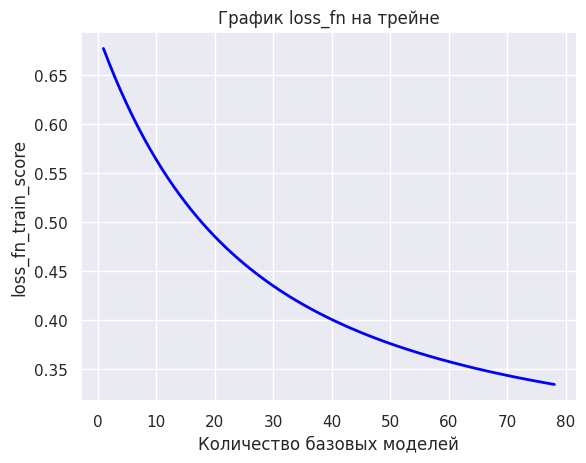

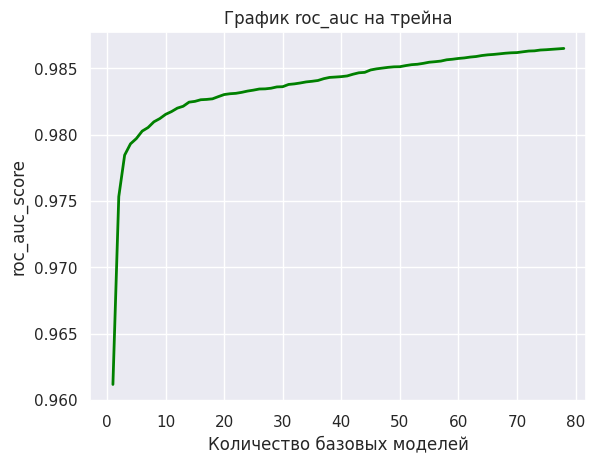

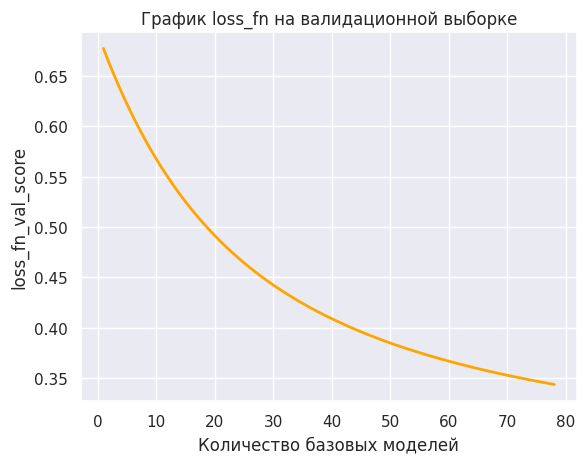

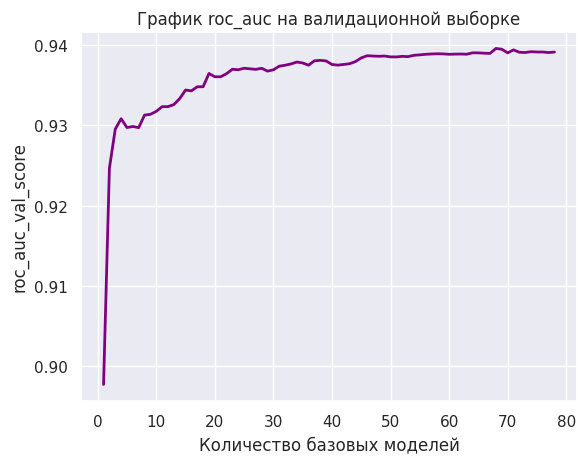

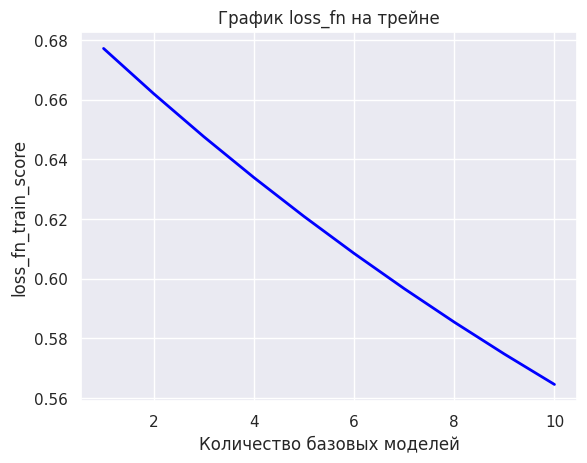

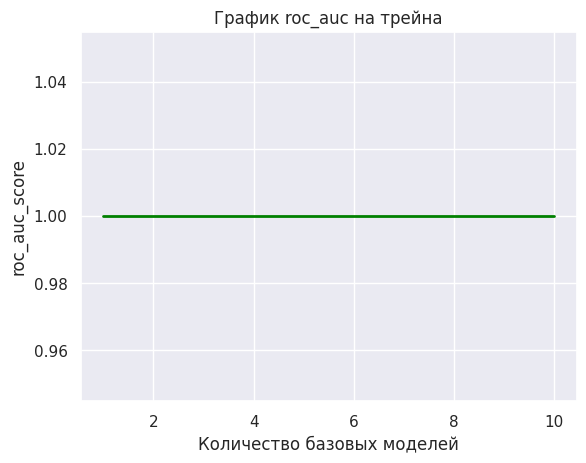

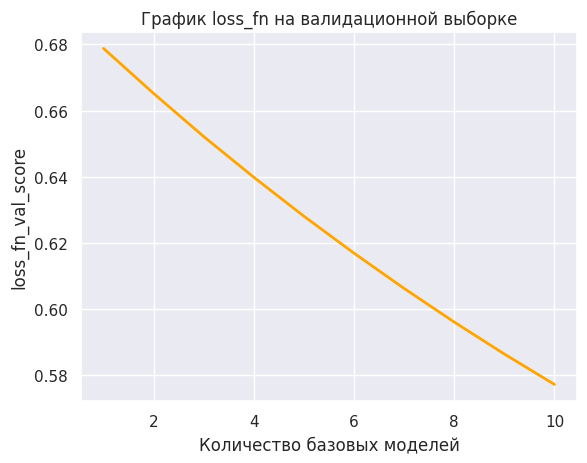

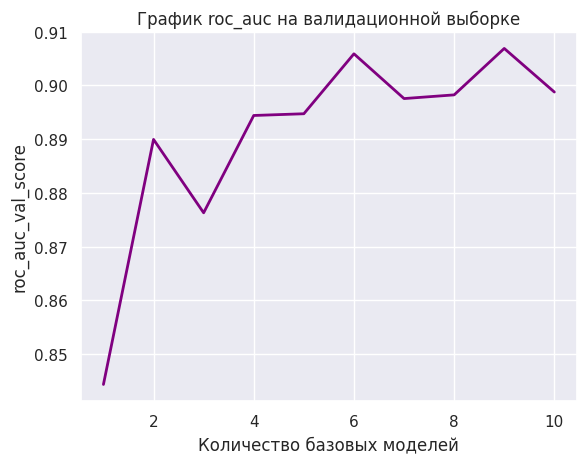

In [ ]:
best_params = study.best_params
best_params["base_model_params"] = {"max_depth": best_params.pop("max_depth")}
best_boosting = Boosting(
    **best_params,
    eval_set=eval_set
)
best_boosting.fit(X_train, y_train, plot=True)
default_boosting = Boosting(
    eval_set=eval_set
)
default_boosting.fit(X_train, y_train, plot=True)

In [ ]:
optuna.visualization.plot_param_importances(study) #покажем какие параметры были наиболее важными

### 3.2. Глубокая оптимизация (1 балл)

Помимо эффективного перебора гиперпараметров, `optuna` предлагает более тонкий контроль над самой процедурой обучения. Улучшите процедуру оптимизации следующим образом:

1. Посмотрите, как в `optuna` устроена запись в хранилища, и добавьте это в пайплайн оптимизации. Без указания БД все запуски оптуны сотрутся, как только закончится сессия. Более того, так можно распараллелить процесс оптимизации на несколько машин
2. Посмотрите, как можно контролировать процесс обучения бустинга при помощи прунера. У библиотечных имплементаций есть уже готовые, их можно использовать пунктом ниже. Для кастомной модели возьмите что-то из `optuna.pruners`. Идея прунера — не обучать бустинг до конца, если по истории видно, что другие бустинги на этом этапе статистически лучше.
3. Добавьте сохранение истории функции потерь и времени обучения в качестве `user_attribute` сразу в `study`. Мы не хотим оптимизировать их напрямую, но они нам понадобится для сравнения моделей в дальнейшем

Добавьте хранилище и юзер атрибуты и посмотрите, ускорилась ли оптимизация с добавлением прунера

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 3.3. Готовые реализации (1 балл)

Библиотек для бустингов существует много, но активно используются лишь три. Ваша задача — попробовать их в деле, посмотреть на их уникальные фишки и понять, что вам нравится больше всего

Возьмите любую из популярных библиотек: <font color='lightblue'>`xgboost`</font>, <font color='lightgreen'>`lightgbm`</font>, <font color='palegoldenrod'>`catboost`</font>.
Ваша задача — взять одну из них, подобрать те же оптимальные параметры, что и выше, плюс что-то, что вам понравилось в них больше всего (может быть абсолютно любая фишка из пунктов выше или что-то, что вы найдете сами, не обязательно эксклюзивное), и сравнить две оптимизированные модели по
- динамике функции потерь (на обучающей и на валидационной выборке)
- времени обучения

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

<font color='plum'>**Вопрос:** Какая архитектура вам нравится больше всего и почему?</font>

<font color='plum'>**Ответ**: ... </font>

### Бонус. Random Forest (0.5 балла)

Если очень захотеть, оптуна может оптимизировать все, что угодно, даже нейросети. Давайте противопоставим бустингу его злейшего врага — алгоритм Random Forest.

Возьмите реализацию случайного леса из <font color='lightgreen'>`lightgbm`</font>. Посмотрите, какие там есть гиперпараметры, переберите что-либо из них вместе с `max_depth` и `n_estimators`.

Сравните его качество и динамику функции потерь (на обучающей и на валидационной выборке) с таковыми у бустинга и сделайте вывод, а нужен ли Random Forest?

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚

### 3.4. Бустинг и вероятности (0.5 балла)

С качеством мы более-менее разобрались, но что насчет вероятностей? Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности?

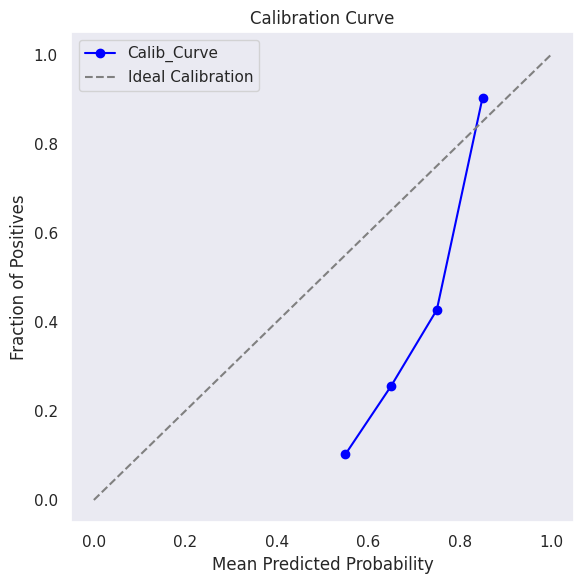

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
#я не успел заботать оптуну, чтобы сделать остальные два задания, поэтому калибровочная кривая будет строиться по лучшим параметрам, подобранным в первом задании
y_proba = best_boosting.predict_proba(X_test)[:, 1]
#скопирую свой код из домашки
def plot_calibration_curve(y_test, preds, ax = None, label=None):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(bin_middle_points, bin_real_ratios, marker='o', label=label, color='blue')
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title('Calibration Curve')
    ax.grid()
    plt.tight_layout()

fig, ax = plt.subplots(figsize=(6,6))
plot_calibration_curve(y_test, y_proba, ax, label='Calib_Curve')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration')
ax.legend()
plt.show()


Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

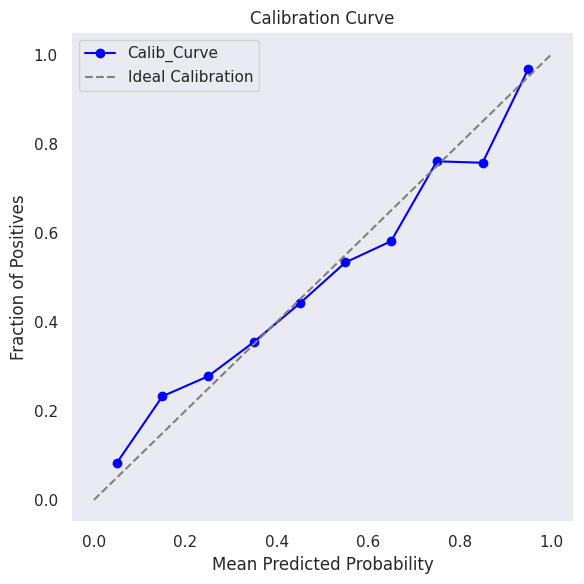

In [ ]:
# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚
from sklearn.linear_model import LogisticRegression
logisticregr = LogisticRegression()
logisticregr.fit(X_train, y_train)
y_proba = logisticregr.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots(figsize=(6,6))
plot_calibration_curve(y_test, y_proba, ax, label='Calib_Curve')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration')
ax.legend()
plt.show()

Как мы видим, логистическая регрессия делает прогнозы более приближенные к идеальной кривой.

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2025 года?

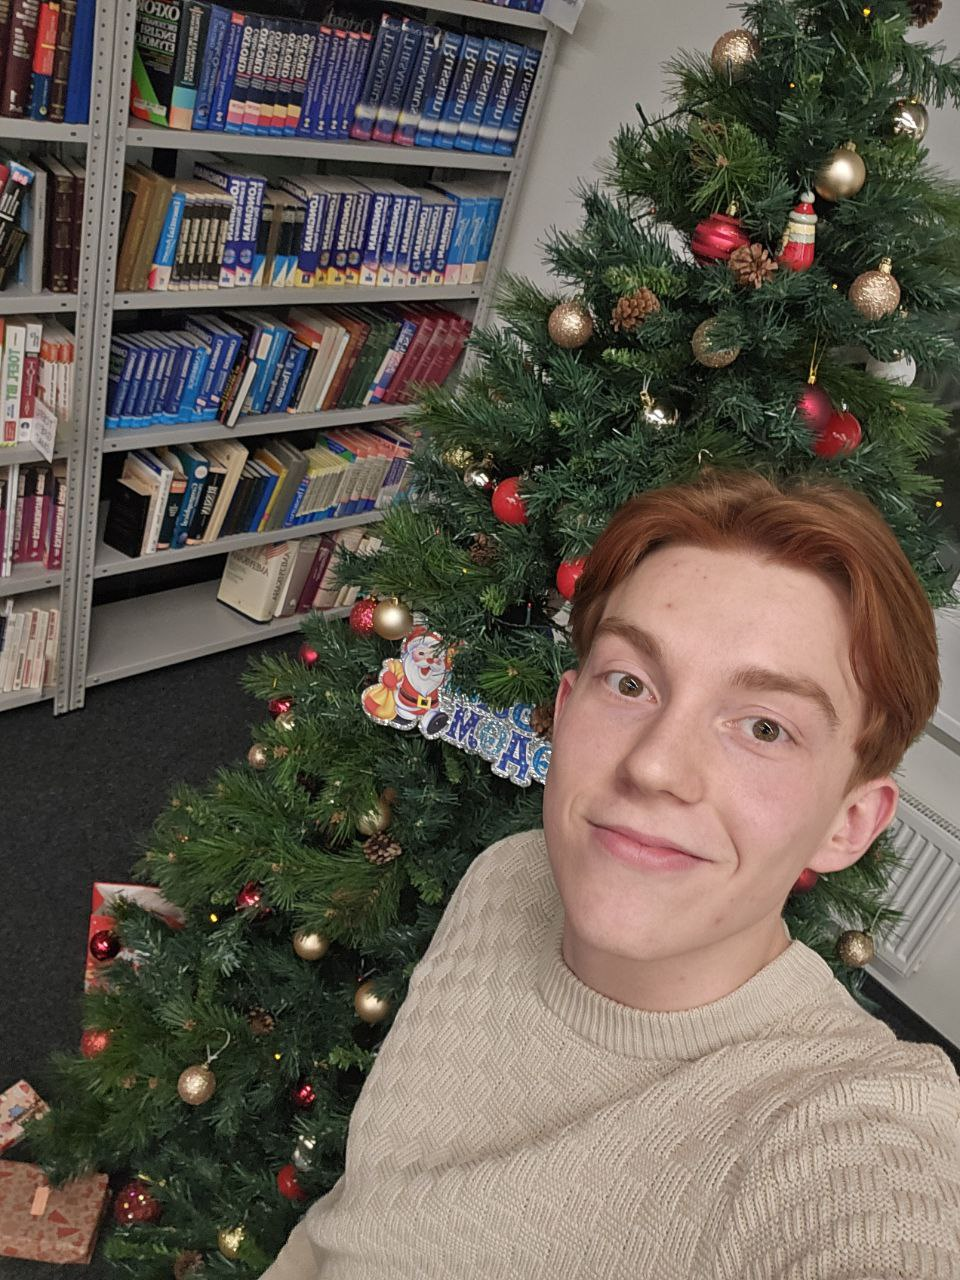

# *𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚*𖣂♱𖠰𖣂↟*𖠰ᨒ↟*𖥧˚